In [1]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
#import mne

# graphical libs
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

# ml libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter #, filtfilt, butter
from collections import deque

#import optuna
#from optuna.samplers import TPESampler

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output
#np.set_printoptions(suppress=True)

# Model serialization
import pickle
import joblib

import serial
import time
import json

In [2]:
# Set requirements
#!pip install -qr ../requirements.txt

In [3]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import add_diff, get_mse, preprocessing_0, preprocessing_1, reset_random_seeds, callbacks # 
from utils.figures import get_signals_plot, get_nogo_plot, get_signals_comparison_plot, plot_history, get_nogo, postporocessing_nogo #get_all_sensors_plot, 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
#PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [4]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in Optuna
#sampler = TPESampler(seed=seed_value) # fix random seed

# 4. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 5. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
    for file in myzip.namelist():
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

mounts.keys()

dict_keys(['free_movements_2', 'gestures_test_2', 'gestures_train_2', 'gestures_protocol_2', 'gestures_protocol', 'gestures_test', 'gestures_train', 'free_movements'])

### Gestures train and test

In [6]:
gestures_train = mounts['gestures_train']

print(gestures_train.shape)
gestures_train.head(2)

(28976, 65)


0  1   2     3     4     5     6   7  8   9  ...  GYR2  ENC0  ENC1  ENC2  \
0  10  8  29  2846  2929  2873  2598  24  8   6  ...    32    37    50    54   
1  10  8  28  2846  2931  2873  2597  24  8  13  ...    31    37    50    54   

   ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
0    44     5     0       0     0  1174956  
1    44     5     0       0     0  1174989  

[2 rows x 65 columns]

In [7]:
gestures_test = mounts['gestures_test']

print(gestures_test.shape)
gestures_test.head(2)

(7244, 65)


0  1   2     3     4     5     6   7  8  9  ...  GYR2  ENC0  ENC1  \
28976  10  9  38  2994  3119  2996  2773  38  9  6  ...    19    25    28   
28977  10  8  35  2989  3117  2996  2766  36  8  6  ...    26    25    28   

       ENC2  ENC3  ENC4  ENC5  BUTTON  SYNC       ts  
28976    32    17     6     0       0     0  2131164  
28977    32    17     6     0       0     0  2131197  

[2 rows x 65 columns]

```Python
# Обозначения
[X features] '0', ..., '49' - каналы OMG датчиков
             'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
[y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
'BUTTON' - не используется
'SYNC' - синхронизация данных с протоколом
'ts' - метка времен
```

In [8]:
# Обозначение колонок для удобства доступа
# [X features] '0', ..., '49' - каналы OMG датчиков
OMG_CH = [str(i) for i in range(50)]

# 'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
ACC_CH = config.ACC_CH

# 'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
GYR_CH = config.GYR_CH

# [y target] = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5'] - координаты пальцев в перчатке GLOVE
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем

# 'BUTTON' - не используется
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

# Обозначение признаков разницы
col_diff_names = [x + '_DIFF' for x in OMG_CH]
COLS = OMG_CH + col_diff_names

# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времен

#assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

print(f"OMG_CH: {OMG_CH}")
print(f"ACC_CH: {ACC_CH}")
print(f"GYR_CH: {GYR_CH}")
print(f"GLOVE_CH: {GLOVE_CH}")
print(f"BUTTON_SYNC_TS_CH: {BUTTON_SYNC_TS_CH}")

print(gestures_train.shape, gestures_test.shape, mounts['gestures_train_2'].shape, mounts['gestures_test_2'].shape)

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']
(28976, 65) (7244, 65) (21320, 65) (5330, 65)


### Protocol

In [9]:
gestures_protocol = mounts['gestures_protocol']
gestures_protocol.head(11)

Thumb  Index  Middle  Ring  Pinky  Thumb_stretch  Index_stretch  \
epoch                                                                    
0        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
1        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
2        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
3        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
4        0.0    0.0     0.0   0.0    0.0            1.0            1.0   
5        1.0    1.0     0.0   0.0    0.0            0.0            0.0   
6        0.0    0.0     1.0   1.0    1.0            0.0            0.0   
7        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
8        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
9        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
10       0.0    0.0     0.0   0.0    0.0            1.0            1.0   

       Middle_stretch  Ring_stretch  Pinky_stretch  Pronation  
epoch                                                          
0                 0.0           0.0            0.0        0.0  
1                 0.0           0.0            0.0        0.0  
2                 0.0           0.0            0.0        0.0  
3                 0.0           0.0            0.0        0.0  
4                 1.0           1.0            1.0        0.0  
5                 0.0           0.0            0.0        0.0  
6                 0.0           0.0            0.0        0.0  
7                 0.0           0.0            0.0        0.5  
8                 0.0           0.0            0.0        0.5  
9                 0.0           0.0            0.0        0.5  
10                1.0           1.0            1.0        0.5

In [10]:
# add OPEN to protocol
mask_open = (gestures_protocol[['Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']] == 1.0).all(axis=1)
gestures_protocol.loc[mask_open, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [11]:
# Смотрим все признаки вместе (для информации) 
gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_train_ext2 = pd.merge(
    mounts['gestures_train_2'],
    mounts['gestures_protocol_2'],
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext2 = pd.merge(
    mounts['gestures_test_2'],
    mounts['gestures_protocol_2'],
    how='left',
    left_on='SYNC',
    right_on='epoch',
)
gestures_train_ext.head()

0  1   2     3     4     5     6   7  8   9  ...  Index  Middle  Ring  \
0  10  8  29  2846  2929  2873  2598  24  8   6  ...    0.0     0.0   0.0   
1  10  8  28  2846  2931  2873  2597  24  8  13  ...    0.0     0.0   0.0   
2  16  8  29  2847  2930  2875  2598  24  8   6  ...    0.0     0.0   0.0   
3  10  8  29  2847  2930  2875  2598  25  8   5  ...    0.0     0.0   0.0   
4   0  8  29  2845  2927  2870  2594  24  8   6  ...    0.0     0.0   0.0   

   Pinky  Thumb_stretch  Index_stretch  Middle_stretch  Ring_stretch  \
0    0.0            0.0            0.0             0.0           0.0   
1    0.0            0.0            0.0             0.0           0.0   
2    0.0            0.0            0.0             0.0           0.0   
3    0.0            0.0            0.0             0.0           0.0   
4    0.0            0.0            0.0             0.0           0.0   

   Pinky_stretch  Pronation  
0            0.0        0.0  
1            0.0        0.0  
2            0.0        0.0  
3            0.0        0.0  
4            0.0        0.0  

[5 rows x 76 columns]

In [12]:
gestures_train['ts'].head()

0    1174956
1    1174989
2    1175022
3    1175055
4    1175088
Name: ts, dtype: int64

In [13]:
mounts['free_movements'].head(2)

0  1   2     3     4     5     6   7  8  9  ...  GYR2  ENC0  ENC1  ENC2  \
0   5  6  24  2793  2838  2871  2635  28  5  5  ...    34    26    37    45   
1  10  8  29  2829  2859  2877  2640  29  8  6  ...    35    26    37    46   

   ENC3  ENC4  ENC5  BUTTON  SYNC      ts  
0    33    21     0       0     5  434007  
1    33    21     0       0     5  434040  

[2 rows x 65 columns]

## Composition of X_train

In [14]:
X_train_1, X_test_1 = gestures_train[OMG_CH].values, gestures_test[OMG_CH].values #56
# Предобработка скользящим окном
#X_train, X_test = X_train.rolling(window=3).mean().dropna(axis=0), X_test.rolling(window=3).mean().dropna(axis=0)

display('X_train', pd.DataFrame(X_train_1, columns=OMG_CH).head(2))

y_train_1, y_test_1 = gestures_train[GLOVE_CH].values, gestures_test[GLOVE_CH].values

# Предобработка скользящим окном
#y_train, y_test =  y_train.iloc[2:,:], y_test.iloc[2:,]
display('y_train', pd.DataFrame(y_train_1, columns=GLOVE_CH).head(2) )#'y_test', y_test.head(2)

'X_train'

0  1   2     3     4     5     6   7  8   9  ...  40  41  42  43  44  45  \
0  10  8  29  2846  2929  2873  2598  24  8   6  ...  33  31  11  12   8   5   
1  10  8  28  2846  2931  2873  2597  24  8  13  ...  32  28  10  11   8   5   

   46  47  48  49  
0   8  15  36  33  
1   8  13  32  25  

[2 rows x 50 columns]

'y_train'

ENC0  ENC1  ENC2  ENC3  ENC4
0    37    50    54    44     5
1    37    50    54    44     5

In [15]:
gestures_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [16]:
gestures_test.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

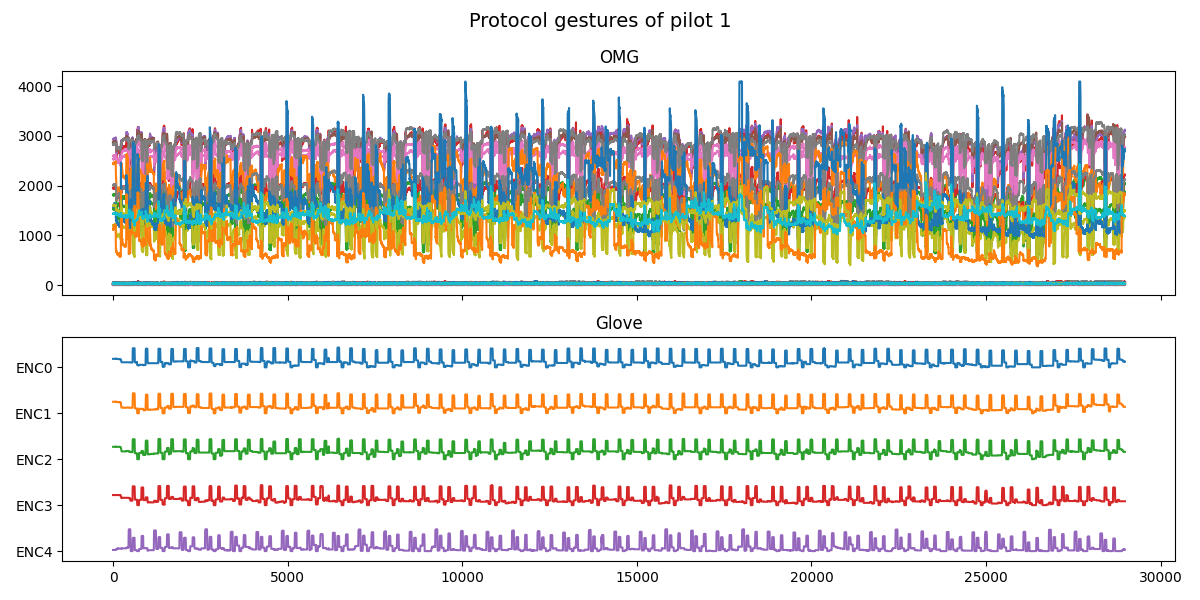

In [17]:
get_signals_plot(X_train_1, y_train_1, title='Protocol gestures of pilot 1')

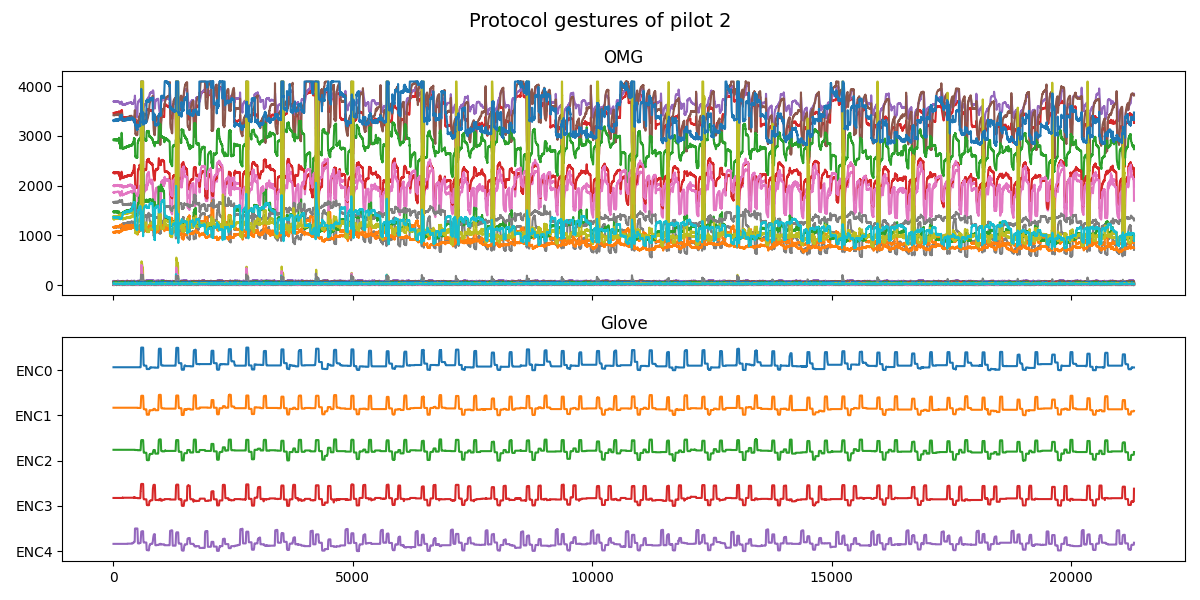

In [18]:
X_train_2, X_test_2 = mounts['gestures_train_2'][OMG_CH].values, mounts['gestures_test_2'][OMG_CH].values #56

y_train_2, y_test_2 = mounts['gestures_train_2'][GLOVE_CH].values, mounts['gestures_test_2'][GLOVE_CH].values
get_signals_plot(X_train_2, y_train_2, title='Protocol gestures of pilot 2')

In [19]:
# Combine 2 pilots data
X_train_acc_1, X_train_acc_2 = mounts['gestures_train'][ACC_CH].values, mounts['gestures_train_2'][ACC_CH].values #56
X_train_prn_1, X_train_prn_2 = gestures_train_ext['Pronation'].values, gestures_train_ext2['Pronation'].values
X_train_gyr_1, X_train_gyr_2 = mounts['gestures_train'][GYR_CH].values, mounts['gestures_train_2'][GYR_CH].values

#gestures_test_ext['Pronation'].values

X_train_acc = np.concatenate((X_train_acc_1,  X_train_acc_2), axis=0) 
#gestures_test_ext['Pronation'].values,, gestures_test_ext2['Pronation'].values
X_train_prn = np.concatenate((X_train_prn_1, X_train_prn_2), axis=0)
X_train_gyr = np.concatenate((X_train_gyr_1, X_train_gyr_2), axis=0) 
y_train = np.concatenate((y_train_1, y_train_2), axis=0)

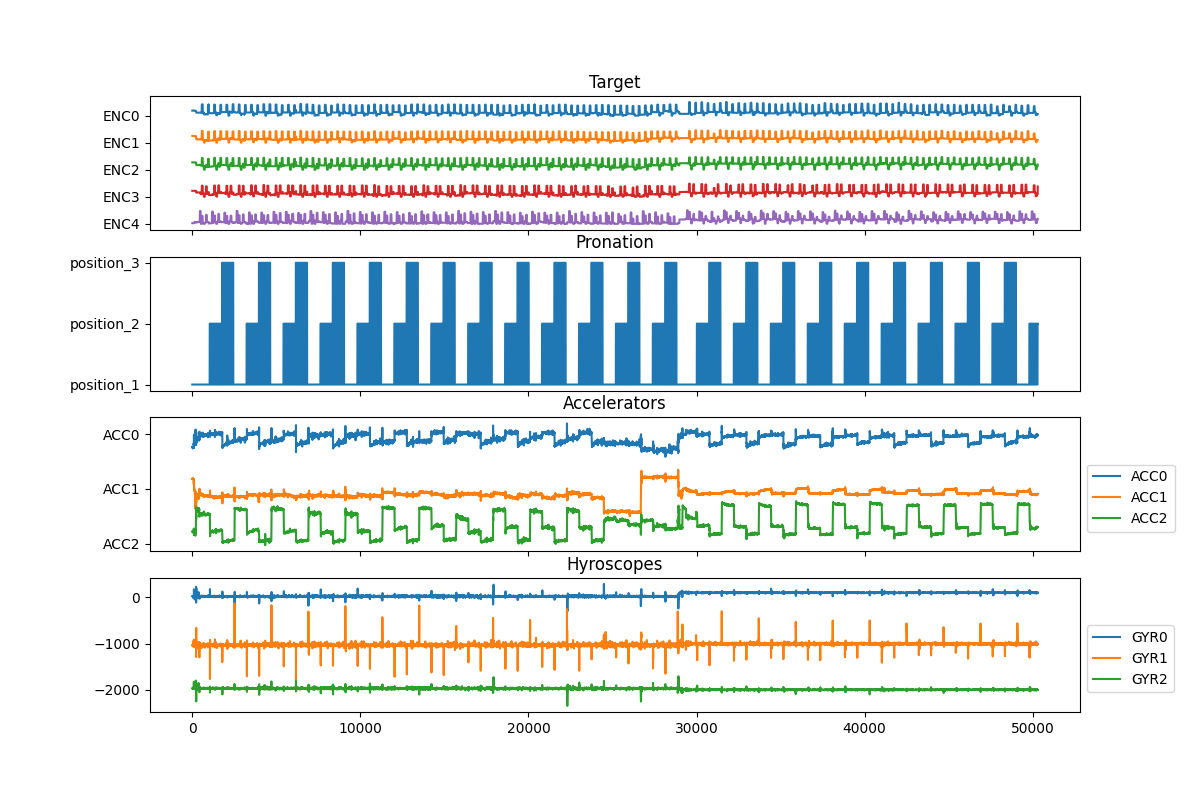

In [20]:
dist = -np.arange(3) * 300
dist1 = -np.arange(5)* 200
dist2 = -np.arange(3) * 1000

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 8)) # plt.sca(axes)
ax[0].plot(y_train+dist1)
ax[0].set_title('Target')
ax[0].yaxis.set_ticks(dist1, GLOVE_CH)

ax[1].plot(X_train_prn)
ax[1].set_title('Pronation')
ax[1].yaxis.set_ticks(np.linspace(0,1,3), ['position_1', 'position_2', 'position_3'])

ax[2].plot(X_train_acc+dist)
ax[2].yaxis.set_ticks(dist, ACC_CH)
ax[2].legend(ACC_CH, bbox_to_anchor=(1, 0.7))
ax[2].set_title('Accelerators')

ax[3].plot(X_train_gyr + dist2)
ax[3].set_title('Hyroscopes')
ax[3].legend(GYR_CH, bbox_to_anchor=(1, 0.7));

#plt.show()

#gestures_train[ACC_CH].head(2)

In [21]:
# Pronat = pd.get_dummies(gestures_protocol['Pronation'], prefix='Pronation')
# gestures_protocol = pd.concat([gestures_protocol, Pronat], axis=1)
# gestures_protocol.drop(['Pronation'], axis=1, inplace=True)

# # Features list
# PRON = ['Pronation_0.0', 'Pronation_0.5', 'Pronation_1.0']

# gestures_protocol.head(2)

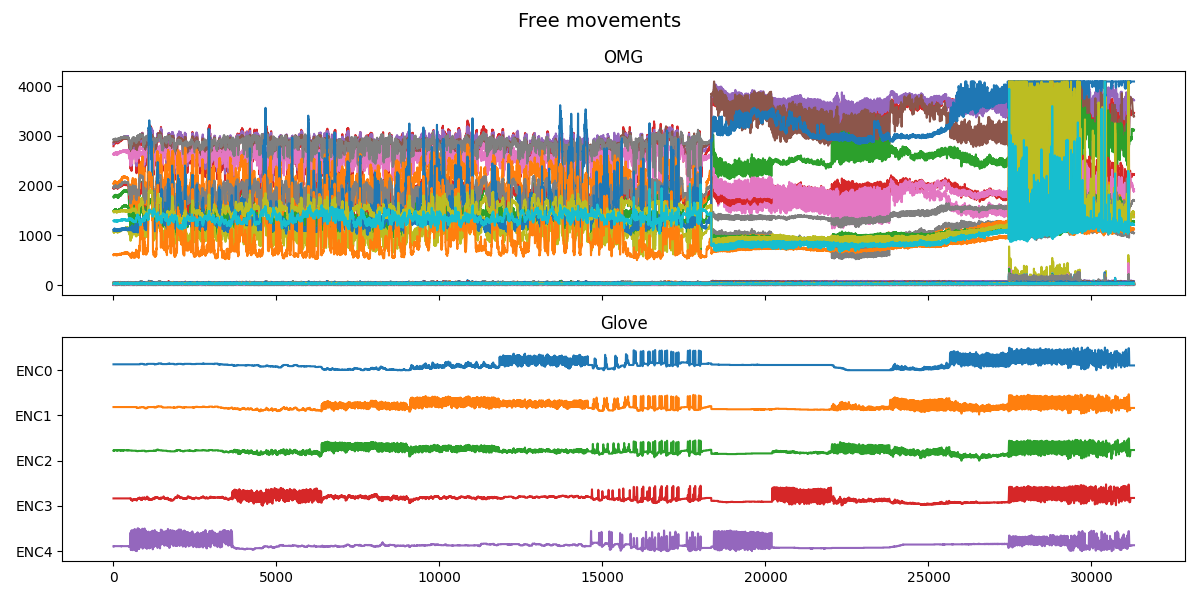

In [22]:
# Combine 2 pilots data
X_free_1, y_free_1 = mounts['free_movements'][OMG_CH].values, mounts['free_movements'][GLOVE_CH].values
X_free_2, y_free_2 = mounts['free_movements_2'][OMG_CH].values, mounts['free_movements_2'][GLOVE_CH].values

X_free_raw, y_free_raw =  np.concatenate((X_free_1, X_free_2), axis=0), np.concatenate((y_free_1, y_free_2), axis=0)

get_signals_plot(X_free_raw, y_free_raw, title='Free movements')
#display(X_free.head(2),'X_free', X_free.shape, y_free.head(2),y_free.shape)

In [23]:
# Проверка есть ли отрицательные скорости в датасете
mask = mounts['gestures_train']['ACC0'] < 0
mounts['gestures_train'][mask][ACC_CH].head(2)

ACC0  ACC1  ACC2
0   -71    56    67
1   -71    56    68

# Preprocessing

In [24]:
# Combine 2 pilots data
X_train_raw, X_test_raw = np.concatenate((X_train_1, X_train_2), axis=0), np.concatenate((X_test_1, X_test_2), axis=0)
y_train, y_test = np.concatenate((y_train_1, y_train_2), axis=0), np.concatenate((y_test_1, y_test_2), axis=0)


# X_train_raw.shape

# X_train = np.c_[X_train_raw[:-1], y_train[:-1]]
# X_test = np.c_[X_test_raw[:-1], y_test[:-1]]
# y_train = y_train[1:]
# y_test = y_test[1:]

In [25]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# dist = - np.arange(5) * 200
# plt.plot(y_train + dist)
# ax.yaxis.set_ticks(dist, labels=GLOVE_CH)

# plt.suptitle('Signals smoothing')
# plt.grid()

In [26]:
# Smoothing of sensor signals
#X_train = np.transpose([savgol_filter(X_train_raw[:,i], window_length=16, polyorder=3) for i in range(X_train_raw.shape[1])]) 
#X_test = np.transpose([savgol_filter(X_test_raw[:,i], window_length=16, polyorder=3) for i in range(X_test_raw.shape[1])])

In [27]:
# # Smoothing of sensor 0 signal
# temp = pd.DataFrame({
#     'original':X_train_raw[:1000,3], 
#     'Savitsky golay filter':np.round(X_train[:1000,3]), 
#     #'digital filter':X_train.iloc[:,0]
# })

# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# sns.lineplot(temp)
# plt.suptitle('Signals smoothing')
# plt.grid()

In [28]:
# Scaling values
scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test, = scaler.fit_transform(X_train_raw), scaler.transform(X_test_raw) 
#X_free =, scaler.transform(X_free)


#display(pd.DataFrame(X_train, columns=COLS).head(1))

joblib.dump(scaler, os.path.join(config.PATH_MODEL, "MinMax_scaler"+'.bin'), compress=True) 

['../models/MinMax_scaler.bin']

In [29]:
# Add differential values
X_train, X_test  = add_diff(X_train, shift_=5), add_diff(X_test, shift_=5) #, X_free, add_diff(X_free_raw, shift_=5)

In [30]:
# # Read config
# with open('../config/data_config.json', mode='r', encoding='utf-8') as config_file:
#     cfg = json.load(config_file)
    
#     # add new entrie
#     cfg.update(scaler_name="MinMax_scaler.bin")

# # write config
# with open('../config/data_config.json', mode='w') as f:   
#     f.write(json.dumps(cfg, indent=2))

## NOGO

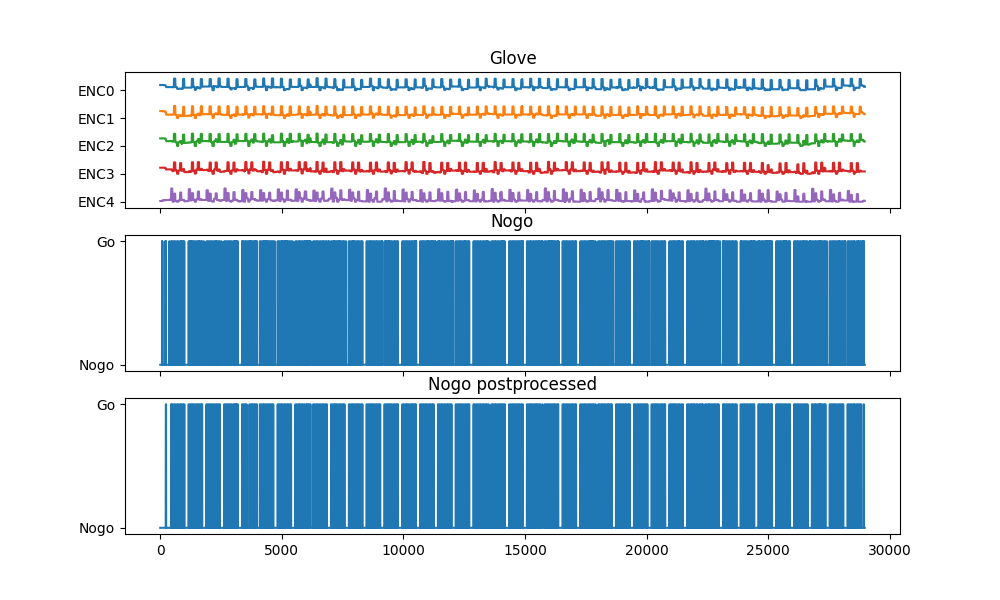

In [31]:
get_nogo_plot(y_train_1, (0, 28970))

In [32]:
# Concatenation of 2 pilots' accelerators data 
X_train_ag_1, X_test_ag_1 = mounts['gestures_train'][ACC_CH].values, mounts['gestures_test'][ACC_CH].values
X_train_ag_2, X_test_ag_2 = mounts['gestures_train_2'][ACC_CH].values, mounts['gestures_test_2'][ACC_CH].values
X_free_ag_1, X_free_ag_2 = mounts['free_movements'][ACC_CH].values, mounts['free_movements_2'][ACC_CH].values

X_train_ag, X_test_ag, X_free_ag = np.concatenate((X_train_ag_1, X_train_ag_2), axis=0), np.concatenate((X_test_ag_1, X_test_ag_2), axis=0), np.concatenate((X_free_ag_1, X_free_ag_2), axis=0)

In [33]:
y_train_post, y_test_post, y_free_post = postporocessing_nogo(get_nogo(y_train)), postporocessing_nogo(get_nogo(y_test)), postporocessing_nogo(get_nogo(y_free_raw))

#scaler.fit_transform(X_train)

#y_train, y_test = np.c_[y_train_ag, np.r_[np.zeros(1), y_train_ag]], np.c_[y_test_ag, np.r_[np.zeros(1), y_test_ag]]
y_train_ag, y_test_ag, y_free_ag = np.r_[np.zeros(1), y_train_post], np.r_[np.zeros(1), y_test_post], np.r_[np.zeros(1), y_free_post]

# Shape : (50296, 50)
#X_train_raw.shape 

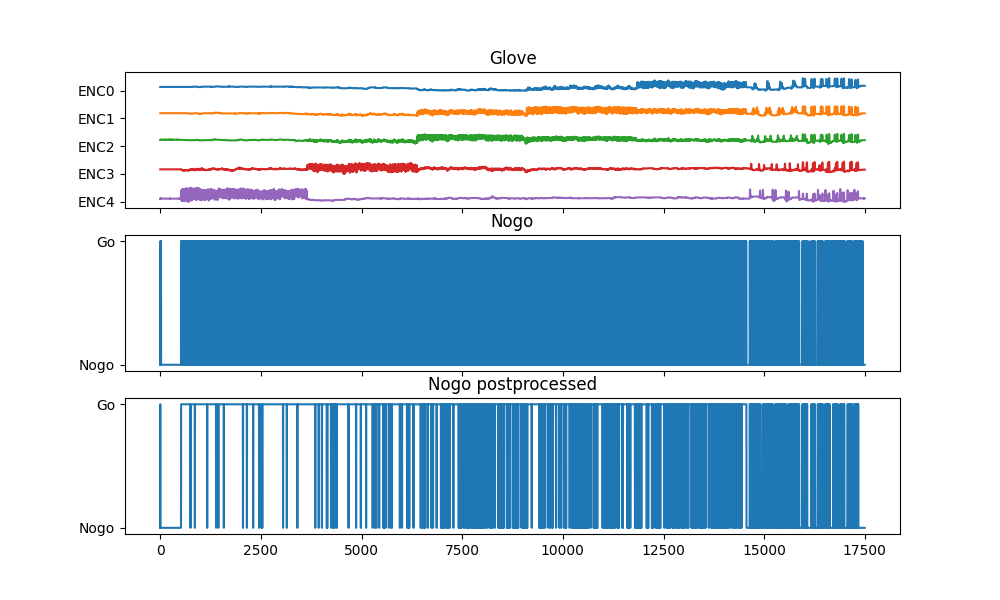

In [34]:
get_nogo_plot(y_free_raw, (0, 17500))

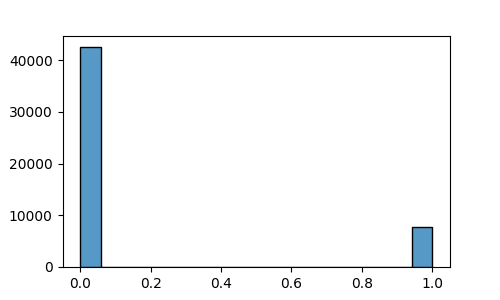

In [35]:
fig, ax = plt.subplots(figsize=(5, 3)) 
sns.histplot(y_train_ag)
plt.show()

In [36]:
X_test_ag, X_valid_ag, y_test_ag, y_valid_ag  = train_test_split(X_test_ag, y_test_ag, test_size=0.5, random_state=seed_value)

log_reg = LogisticRegression(
    #solver='sag', 
    max_iter=70,
    random_state=seed_value)

# Model training
log_reg.fit(X_train_ag, y_train_ag) 

# Prediction of target values
y_pred = log_reg.predict(X_test_ag)

# Metrics report
print(classification_report(y_test_ag, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      5325
         1.0       0.00      0.00      0.00       962

    accuracy                           0.85      6287
   macro avg       0.42      0.50      0.46      6287
weighted avg       0.72      0.85      0.78      6287



In [37]:
# Prediction of free_movements values
y_pred1 = log_reg.predict(X_free_ag)
# Metrics report
print(classification_report(y_free_ag, y_pred1))

              precision    recall  f1-score   support

         0.0       0.25      1.00      0.40      7889
         1.0       0.00      0.00      0.00     23418

    accuracy                           0.25     31307
   macro avg       0.13      0.50      0.20     31307
weighted avg       0.06      0.25      0.10     31307



# Modeling

### Linear regression

In [38]:
X_train_ag, X_test_ag, = np.concatenate((X_train_ag_1, X_train_ag_2), axis=0), np.concatenate((X_test_ag_1, X_test_ag_2), axis=0)
#X_train, X_test = np.c_[X_train, log_reg.predict(X_train_ag)], np.c_[X_test, log_reg.predict(X_test_ag)] 

In [39]:
y_train_post, y_test_post, y_free_post = postporocessing_nogo(get_nogo(y_train)), postporocessing_nogo(get_nogo(y_test)), postporocessing_nogo(get_nogo(y_free_raw))

#y_train, y_test = np.c_[y_train_ag, np.r_[np.zeros(1), y_train_ag]], np.c_[y_test_ag, np.r_[np.zeros(1), y_test_ag]]
y_train_ag, y_test_ag, y_free_ag = np.r_[np.zeros(1), y_train_post], np.r_[np.zeros(1), y_test_post], np.r_[np.zeros(1), y_free_post]

# Shape : (50296, 50)
#X_train_raw.shape 

Test
ENC0  134.876081
ENC1   99.462985
ENC2  106.844358
ENC3  131.912669
ENC4  271.336250

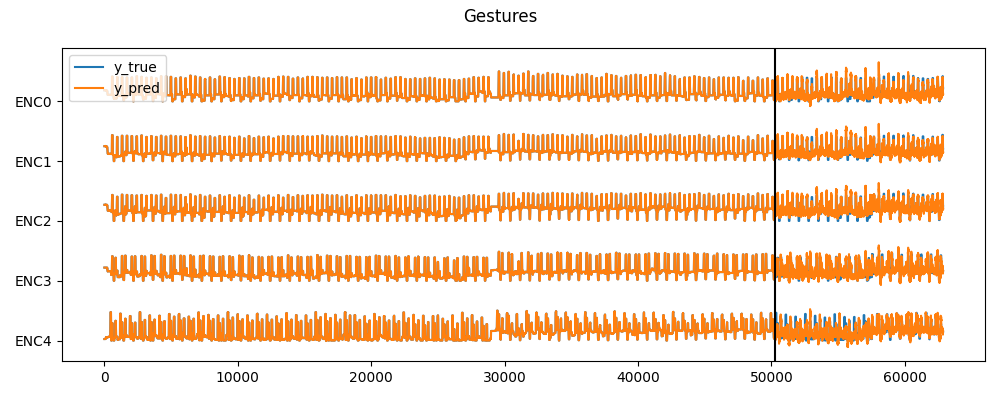

In [40]:
# Creation an instance
lin = LinearRegression()

# Train the Model
lin.fit(X_train, y_train)

# Predict target values
y_pred = lin.predict(X_test)#.round() 
 
# Display metrics
get_mse(y_test, y_pred)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred=y_pred, only_test=1)

In [41]:
temp = pd.DataFrame({ 
    'raw_test':[146.651105, 108.340862, 113.975744, 138.810561, 282.818435],
    'Savgol (15, 2)': [131.804835, 94.625656, 101.403452, 126.399077, 267.895340],
    'add_diff (5)': [134.876081, 99.462985, 106.844358, 131.912669, 271.336250],
    'Savgol + add_diff (5)':[121.720603, 87.424719, 95.642588, 122.669173, 257.470227],
    '+ Nogo(OMG+GYR+ACC':[120.392064, 86.271074, 94.639965, 121.464624, 255.085692],
    '+ Nogo(ACC+ GYR':[120.803858, 86.670098, 94.978771, 121.195955, 254.788457],
    '+ Nogo(ACC':[120.808092, 86.672703, 94.999821, 121.389487, 255.118582]

    
}, index=['ENC0','ENC1','ENC2','ENC3','ENC4']) #, index=GLOVE_CH 

temp.round(1)

raw_test  Savgol (15, 2)  add_diff (5)  Savgol + add_diff (5)  \
ENC0     146.7           131.8         134.9                  121.7   
ENC1     108.3            94.6          99.5                   87.4   
ENC2     114.0           101.4         106.8                   95.6   
ENC3     138.8           126.4         131.9                  122.7   
ENC4     282.8           267.9         271.3                  257.5   

      + Nogo(OMG+GYR+ACC  + Nogo(ACC+ GYR  + Nogo(ACC  
ENC0               120.4            120.8       120.8  
ENC1                86.3             86.7        86.7  
ENC2                94.6             95.0        95.0  
ENC3               121.5            121.2       121.4  
ENC4               255.1            254.8       255.1

In [42]:
# Save model to the given path in the pkl format
model_name = 'lin'
full_path = os.path.join(config.PATH_MODEL, model_name + '.pkl')  
 
with open(full_path, 'wb') as f:
    pickle.dump(lin, f)

### Нейронная сеть

In [45]:
reset_random_seeds(seed_value)

#np.expand_dims(X_train, axis=0).shape

n_timesteps = None
b_size = 64
n_channels = X_train.shape[1] # gestures_train[[*OMG_CH, *ACC_CH, *GYR_CH]].shape[1] 
output_units = y_train.shape[1]

# model architecture
input_layer = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(units=100, 
                         recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3)
                         )(x) 
x = tf.keras.layers.Dropout(0.3)(x) #0.3
output_layer = tf.keras.layers.Dense(units=output_units, activation='elu')(x)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=output_layer,
    name="model_LSTM"
    )

model.summary()

tf.keras.backend.clear_session()

reset_random_seeds(seed_value)

model.compile(
    loss="mean_squared_error", 
    metrics=['mse'], 
    optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=0.001) #learning_rate=0.001
    )

callbacks_list = callbacks(1e-04)

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 batch_normalization (BatchN  (None, None, 100)        400       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 81,305
Trainable params: 81,105
Non-trainable params: 200
__________________________________________________

In [46]:
history = model.fit(
            x = np.expand_dims(X_train, 1),
            y = y_train,
            batch_size=b_size,
            validation_split=0.2,
            epochs=1500,
            verbose=1,          
            callbacks=callbacks_list
        )
clear_output(wait=False)

In [47]:
#plot_model(model)

In [70]:
# Save LSTM model
#model.save(os.path.join(config.PATH_MODEL, model.name))

INFO:tensorflow:Assets written to: ../models/model_LSTM\assets


INFO:tensorflow:Assets written to: ../models/model_LSTM\assets


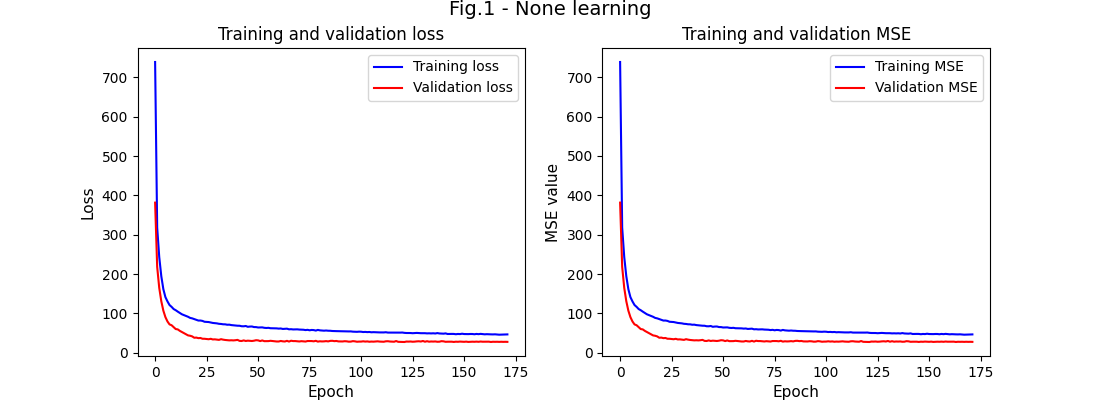

In [48]:
plot_history(history)

## Prediction

In [78]:
np.expand_dims(X_train, 1).shape

(50296, 1, 100)

393/393 [==============================] - 1s 1ms/step


Test
ENC0  50.175078
ENC1  22.707794
ENC2  33.064971
ENC3  42.493959
ENC4  89.097984

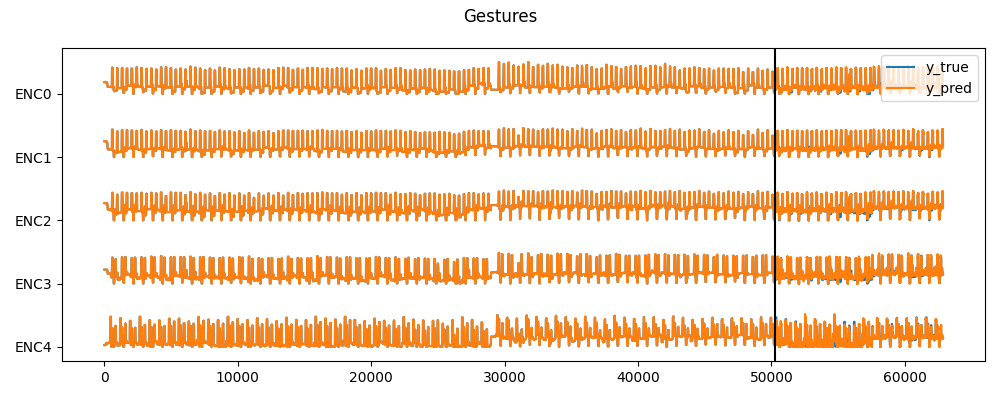

In [49]:
y_pred_train = model.predict(np.expand_dims(X_train, 1)) # [*OMG_CH, *ACC_CH, *GYR_CH] 
#y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train['ts'])

y_pred_test = model.predict(np.expand_dims(X_test, 1)) #[*OMG_CH, *ACC_CH, *GYR_CH]
#y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test['ts'])

# Display metrics
get_mse(y_test, y_pred_test)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred_test, only_test=1)

## Postprocessing

In [50]:
preproc_coef = 0.57

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred_test)
y_pred_test_proc[0] = y_pred_test[0]


for i in range(1, len(y_pred_test)):
    y_pred_test_proc[i] = postprocessing(y_pred_test[i], y_pred_test[i-1])

# округление
#y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100)) 

# Display metrics
get_mse(y_test, y_pred_test_proc)

Test
ENC0  49.580324
ENC1  22.316049
ENC2  32.979481
ENC3  42.438842
ENC4  86.341976

In [51]:
temp = pd.DataFrame({ 
    'NN':[47.746350, 23.173296, 30.299070,35.895645,100.017356],
    'NN_postprocessing': [47.529585, 22.975903, 30.493320, 36.210037, 98.337283],
    'NN+nogo': [50.124183, 23.817094, 32.627123, 39.444633, 103.019906],
    'NN+nogo+postprocessing':[50.011611, 23.623588, 32.625974, 39.544854, 101.297916]
   
}, index=['ENC0','ENC1','ENC2','ENC3','ENC4']) #, index=GLOVE_CH 

temp.round(1)


NN  NN_postprocessing  NN+nogo  NN+nogo+postprocessing
ENC0   47.7               47.5     50.1                    50.0
ENC1   23.2               23.0     23.8                    23.6
ENC2   30.3               30.5     32.6                    32.6
ENC3   35.9               36.2     39.4                    39.5
ENC4  100.0               98.3    103.0                   101.3

## Model for inference

In [134]:
# model  for inference
n_channels = X_train.shape[1]
n_timesteps = None

output_units = y_train.shape[1]
hidden_size = 100

model_input = tf.keras.Input(batch_shape=(1, 1, n_channels))
x = tf.keras.layers.BatchNormalization()(model_input)

x = tf.keras.layers.LSTM(
    units=hidden_size,
    return_sequences=True,
    #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
    # return_state=True,
    # last state for each sample at index i in a batch will be used 
    # as initial state for the sample of index i in the following batch
    stateful=True,
    # speed-up a RNN, but more memory-intensive.
    # only suitable for short sequences.
    unroll=True
)(x)

x = tf.keras.layers.Dropout(0.5)(x)

model_output = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ),
)(x)

model_stateful = tf.keras.Model(
    inputs=[model_input],
    outputs=[model_output],
    name='model_stateful'
)

model_stateful.set_weights(model_stateful.get_weights())

model_stateful.summary()

Model: "model_stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(1, 1, 100)]             0         
                                                                 
 batch_normalization_10 (Bat  (1, 1, 100)              400       
 chNormalization)                                                
                                                                 
 lstm_10 (LSTM)              (1, 1, 100)               80400     
                                                                 
 dropout_6 (Dropout)         (1, 1, 100)               0         
                                                                 
 time_distributed_5 (TimeDis  (1, 1, 5)                505       
 tributed)                                                       
                                                                 
Total params: 81,305
Trainable params: 81,105
Non-tr

In [74]:
# real data
check_data = X_train[:1]#.copy()
print('before reshaping', check_data.shape)
check_data = np.expand_dims(check_data, 1)
print('after reshaping', check_data.shape)
len_check_data = check_data.shape[1]

# print(len_check_data, check_data.shape)
# check_data[:, :3]

before reshaping (1, 100)
after reshaping (1, 1, 100)


In [135]:
y_pred = model_stateful.predict(check_data)
print(y_pred.shape)
# y_pred[:, :10]

1/1 [==============================] - 0s 90ms/step
(1, 1, 5)


In [75]:
%%time

model_stateful.reset_states()

y_pred_stateful = []

time_start = time.time()

for i in range(check_data.shape[1]):
    embedding_stateful = model_stateful(check_data[:, [i]], training=False)
    y_pred_stateful.append(embedding_stateful.numpy())
    
time_end = time.time()
ts = (time_end - time_start) / len_check_data
    
y_pred_stateful = np.hstack(y_pred_stateful)

print(f"Avg time of {len_check_data} iters: {ts:.4f}")
print(y_pred_stateful.shape)
# y_pred_stateful[:, :10]

Avg time of 1 iters: 0.0085
(1, 1, 5)
CPU times: total: 0 ns
Wall time: 8.52 ms


# Real-time inference

In [52]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils

In [101]:
df_sim = mounts['gestures_train'].copy()#.iloc[:10000]
df_sim = df_sim.values[:10000,:50].astype(np.int16)
df_sim.shape

(10000, 50)

In [115]:
# Возьмем элемент 460 для наглядности
x = df_sim[460]
x

array([   5,    6,   13, 2237, 2417, 2740, 2535,   22,    8,    6,    9,
         23, 1296, 1449,   38,   44, 2497, 2844,   28,    5,    4, 1551,
       1101,   36,    9,    7,   30, 1683, 1007,   14, 1163,  638,   22,
         10,    5,    4,    9,   42, 1434, 1503,   32,   28,    0,   11,
          7,    6,    9,   14,   33,   28], dtype=int16)

In [117]:
# Scaling
scaler = joblib.load(os.path.join(config.PATH_MODEL, config.scaler_name))

# В исходном состоянии буффер - 6 строк из нулей
buff = np.zeros((6,50))

def preprocessing(x, buff=buff, scaler=scaler):
    buff[5], buff[4], buff[3], buff[2], buff[1] = buff[4], buff[3], buff[2], buff[1], buff[0]
    #x - sample vector
    x_scaled = scaler.transform(x.reshape(1,-1))[0]
    
    buff[0] = x_scaled 
    
    y = np.hstack([x_scaled , buff[0]- buff[1]])
    
    return y, buff 
  

y, buff = preprocessing(x)

In [137]:
x = y.copy()

# loading linear regression model
# with open(os.path.join(config.PATH_MODEL+'lin.pkl'), 'rb') as f:
#     saved_model = pickle.load(f)

# Loading LSTM model
#saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))

# simplified model
saved_model = model_stateful

def inference(x:np.array, saved_model=saved_model)->np.array: #tf.keras.models.load_model(os.path.join(config.PATH_MODEL+'best_model.hdf5'))
    """_summary_

    Args:
        x (np.array): _description_
        saved_model (keras.engine.functional.Functional): model

    Returns:
        _type_: _description_
    """
    x = x.reshape(1,-1)
    
    # Для линейной регрессии
    #y_pred = saved_model.predict(x)[0].round() #y.reshape(1,-1)
    
    # Для LSTM 
    
    #y_pred = saved_model.predict(np.expand_dims(x, 1))[0].round()
    
    # для simplified model
    y_pred = saved_model(np.expand_dims(x, 1))[0][0] #.round()
    y_pred = np.hstack(y_pred)
    return y_pred

predict = inference(x, saved_model=saved_model)
predict

array([0.        , 0.02187937, 0.        , 0.        , 0.        ],
      dtype=float32)

In [80]:
buff_pred = np.zeros((2,5))

In [81]:
def postprocessing(x=predict, buff_pred=buff_pred, preproc_coef=0.57):
    
    
    buff_pred[1], buff_pred[0] = buff_pred[0], np.clip(predict, 0, 100)
    
    if np.mean(buff_pred[1])==0:
        y = x
       
    else:
        y = predict*preproc_coef + buff_pred[1]*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    
    y = np.clip(y, 0, 100)

    return y, buff_pred

res,  buff_pred = postprocessing(predict, buff_pred)
buff_pred 

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [82]:
def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

clipped = commands(res)
clipped

array([[0, 0, 0, 0, 0]])

## Эмуляция

In [92]:
df_sim = gestures_test.iloc[:100]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(100, 65)


In [93]:
TIMEOUT = 0.090 #0.033
DEBUG = True

ts_list = [] 
    
i = 0

buff = np.zeros((6,50))
buff_pred = np.zeros((2,5))

ts_diff = 0 
 
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

ts_old = time.time()

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing(omg_sample)
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed, saved_model=model_stateful)
    
    # [Inference Postprocessing]
    y_postprocessed, buff_pred     = postprocessing(y_predicted)
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)

    
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    

    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        
    
    ts_diff = time.time() - ts_start
    ts_list.append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

#print('Время вычисления', np.mean(ts_list).round(3), 'мс')
#print(ts_start)
#print(time.time())

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 0, TS: 2134431
[[0 0 0 0 0]]


In [94]:
print('Время вычисления', np.mean(ts_list).round(3) , 'с')

Время вычисления 0.055 с


## Inference

### Offline (dataset)

In [64]:
df_sim = gestures_test.iloc[:10000]
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

TIMEOUT = 0.033
DEBUG = True
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

(7244, 65)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (8168, 50)
enc_sample.shape = (8168, 6)
sample_preprocessed.shape = (8168, 50)
y_predicted.shape = (8168, 6)
y_postprocessed.shape = (8168, 6)
y_commands.shape = (8168, 6)


ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 1, 5)

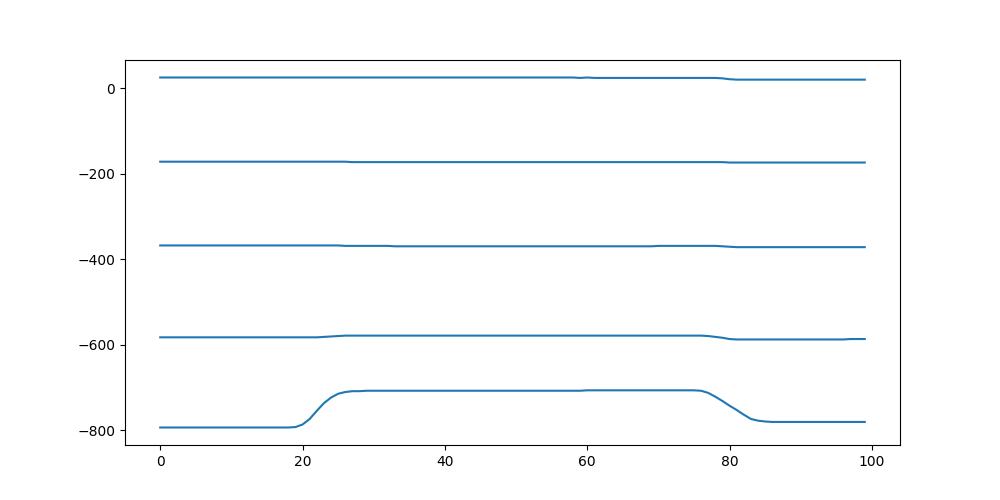

In [241]:
fig = plt.figure(figsize=(10, 5))

lines = []
labels = []

plots = plt.plot(df_sim[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200, c='C0')
lines += [plots[0]]
labels += ['GLOVE_CH']

plots = plt.plot(y_dct['y_predicted'] - np.arange(len(GLOVE_CH)) * 200, c='C1')
lines += [plots[0]]
labels += ['y_predicted']

plots = plt.plot(y_dct['y_postprocessed'] - np.arange(len(GLOVE_CH)) * 200, c='C2')
lines += [plots[0]]
labels += ['y_postprocessed']

plots = plt.plot(y_dct['y_commands'] - np.arange(len(GLOVE_CH)) * 200, c='C3')
lines += [plots[0]]
labels += ['y_commands']

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 